In [2]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [3]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [4]:
comp_pre = jx.Compartment()
branch_pre = jx.Branch(comp_pre, ncomp=1)
parents_pre = np.asarray([-1])           
cell_pre = jx.Cell(branch_pre, parents=parents_pre)

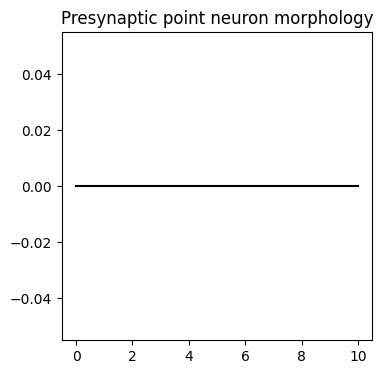

In [5]:
cell_pre.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_pre.vis(ax=ax)
ax.set_title("Presynaptic point neuron morphology");

In [6]:
n_post_comp = 15
comp_post = jx.Compartment()
branch_post = jx.Branch(comp_post, ncomp=n_post_comp)   
parents_post = np.asarray([-1])          
cell_post = jx.Cell(branch_post, parents=parents_post)

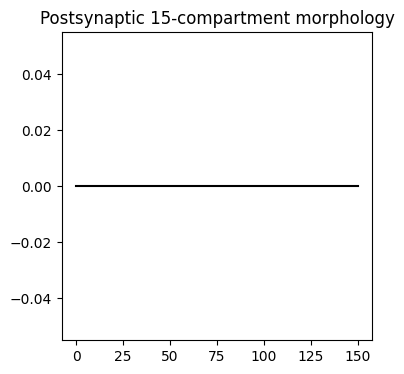

In [7]:
cell_post.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_post.vis(ax=ax)
ax.set_title("Postsynaptic 15-compartment morphology");

In [8]:
num_pre = 8                    
pre_cells = [cell_pre for _ in range(num_pre)]
cells = pre_cells + [cell_post]
net = jx.Network(cells)


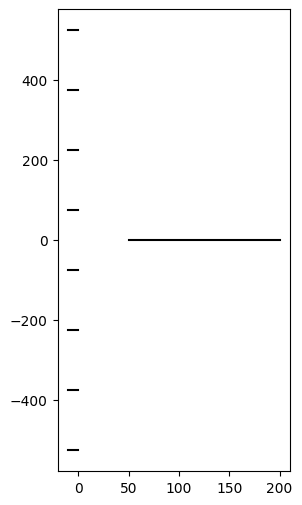

In [9]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[num_pre, 1], within_layer_offset=150, between_layer_offset=200)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

In [10]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [11]:
syn = IonotropicSynapse()
post_idx = num_pre

post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

for pre_idx, comp_idx in zip(range(num_pre), post_comp_indices):
    pre_comp  = net.cell(pre_idx).branch(0).comp(0)           # presyn soma
    post_comp = net.cell(post_idx).branch(0).comp(int(comp_idx))
    connect(pre_comp, post_comp, syn)

print("Ionotropic edges:", net.IonotropicSynapse.edges.shape)

Ionotropic edges: (8, 16)


ABOVE SHOULD YIELD (8, 16) NEED TO FIX BC RE RUNNING ADDS UNOBSERVABLE EDGES

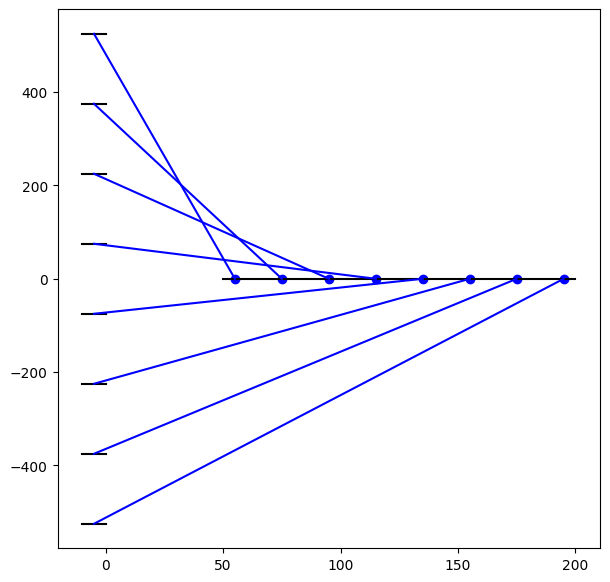

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = net.vis(ax=ax, detail="full")

In [13]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,8,IonotropicSynapse,0,0.5,0.033333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,1,10,IonotropicSynapse,0,0.5,0.166667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,2,12,IonotropicSynapse,0,0.5,0.300000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,3,14,IonotropicSynapse,0,0.5,0.433333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,4,16,IonotropicSynapse,0,0.5,0.566667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
5,5,5,5,18,IonotropicSynapse,0,0.5,0.700000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
6,6,6,6,20,IonotropicSynapse,0,0.5,0.833333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
7,7,7,7,22,IonotropicSynapse,0,0.5,0.966667,0.0001,0.0,0.025,-35.0,10.0,0.2,0


In [14]:
# net.set("IonotropicSynapse_gS", 0.0005)
# net.edges

In [15]:
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 50.0  # ms

In [16]:
time_vec = np.arange(0.0, t_max + dt, dt)

In [17]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(num_pre):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


In [18]:
net.delete_recordings()
# net.cell(post_idx).branch(0).loc(0.0).record()
post_branch = net.cell(post_idx).branch(0)
locs = np.linspace(0.0, 1.0, n_post_comp) 
post_branch.loc(locs).record()



Added 15 recordings. See `.recordings` for details.


In [19]:
traces = jx.integrate(net, delta_t=dt)

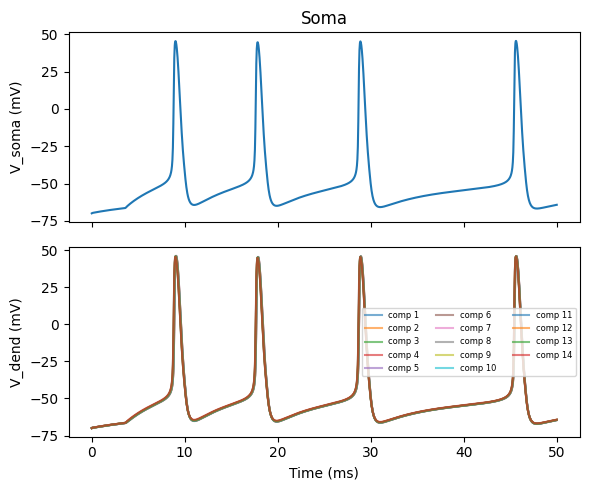

In [20]:
soma_trace = traces[0]
dend_traces  = traces[1:, :]  

T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

# soma
axes[0].plot(time_vec, soma_trace)
axes[0].set_ylabel("V_soma (mV)")
axes[0].set_title("Soma")

# dendrites
for i in range(dend_traces.shape[0]):
    axes[1].plot(time_vec, dend_traces[i], alpha=0.6, label=f"comp {i+1}")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("V_dend (mV)")
axes[1].legend(fontsize=6, ncol=3)

plt.tight_layout()
plt.show()

In [21]:
branch = net.cell(post_idx).branch(0)
for l in locs:
    view = branch.loc(l)
    print(l, np.unique(view.nodes["local_comp_index"]))


0.0 [0]
0.07142857142857142 [0]
0.14285714285714285 [0]
0.21428571428571427 [0]
0.2857142857142857 [0]
0.3571428571428571 [0]
0.42857142857142855 [0]
0.5 [0]
0.5714285714285714 [0]
0.6428571428571428 [0]
0.7142857142857142 [0]
0.7857142857142857 [0]
0.8571428571428571 [0]
0.9285714285714285 [0]
1.0 [0]


In [22]:
branch = net.cell(post_idx).branch(0)

for l in locs:
    view = branch.loc(l)
    inds  = np.unique(view.nodes["global_comp_index"])
    print(l, inds)


0.0 [8]
0.07142857142857142 [9]
0.14285714285714285 [10]
0.21428571428571427 [11]
0.2857142857142857 [12]
0.3571428571428571 [13]
0.42857142857142855 [14]
0.5 [15]
0.5714285714285714 [16]
0.6428571428571428 [17]
0.7142857142857142 [18]
0.7857142857142857 [19]
0.8571428571428571 [20]
0.9285714285714285 [21]
1.0 [22]


In [23]:
rec_view = branch.loc(locs)
print(rec_view.nodes[["global_comp_index", "local_comp_index"]])


    global_comp_index  local_comp_index
8                   8                 0
9                   9                 1
10                 10                 2
11                 11                 3
12                 12                 4
13                 13                 5
14                 14                 6
15                 15                 7
16                 16                 8
17                 17                 9
18                 18                10
19                 19                11
20                 20                12
21                 21                13
22                 22                14


In [24]:
for idx, comp_trace in enumerate(dend_traces):
    print("comp", idx + 1, "shape:", comp_trace.shape)
    max_diff = jnp.max(jnp.abs(soma_trace - comp_trace))
    print(f"max diff soma vs comp {idx+1}: {float(max_diff):.6g}")

comp 1 shape: (2002,)
max diff soma vs comp 1: 4.61865
comp 2 shape: (2002,)
max diff soma vs comp 2: 11.0547
comp 3 shape: (2002,)
max diff soma vs comp 3: 19.549
comp 4 shape: (2002,)
max diff soma vs comp 4: 26.8585
comp 5 shape: (2002,)
max diff soma vs comp 5: 32.8485
comp 6 shape: (2002,)
max diff soma vs comp 6: 36.7572
comp 7 shape: (2002,)
max diff soma vs comp 7: 38.5606
comp 8 shape: (2002,)
max diff soma vs comp 8: 36.7572
comp 9 shape: (2002,)
max diff soma vs comp 9: 32.8485
comp 10 shape: (2002,)
max diff soma vs comp 10: 26.8585
comp 11 shape: (2002,)
max diff soma vs comp 11: 19.549
comp 12 shape: (2002,)
max diff soma vs comp 12: 11.0547
comp 13 shape: (2002,)
max diff soma vs comp 13: 4.61865
comp 14 shape: (2002,)
max diff soma vs comp 14: 4.24372e-11


In [25]:
for k in range(15):
    j = 14 - k
    diff = jnp.max(jnp.abs(traces[k] - traces[j]))
    print(f"pair ({k}, {j}) max diff: {float(diff):.3g}")


pair (0, 14) max diff: 4.24e-11
pair (1, 13) max diff: 7.03e-11
pair (2, 12) max diff: 3.41e-11
pair (3, 11) max diff: 5.05e-11
pair (4, 10) max diff: 3.39e-11
pair (5, 9) max diff: 3.58e-11
pair (6, 8) max diff: 4.22e-11
pair (7, 7) max diff: 0
pair (8, 6) max diff: 4.22e-11
pair (9, 5) max diff: 3.58e-11
pair (10, 4) max diff: 3.39e-11
pair (11, 3) max diff: 5.05e-11
pair (12, 2) max diff: 3.41e-11
pair (13, 1) max diff: 7.03e-11
pair (14, 0) max diff: 4.24e-11


all traces look the same in plotting, but are different (see numerical diffs) though we do have some left-right symmetry going on

TRAINING

In [26]:
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt

In [27]:
net.delete_trainables()
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

params_true = net.get_parameters()


Number of newly added trainable parameters: 8. Total number of trainable parameters: 8


In [28]:
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)

In [29]:
base_amp = i_amp # nA when bit = 1

def simulate(params, pattern, soma_only=True):
    """
    pattern: (n_pre,) binary 0/1
    returns: soma trace (timepoints,)
    """
    # pattern scales the step amplitudes
    amps = base_amp * pattern  # (n_pre,)

    # Jaxley helper: gives one step-current trace per input dimension
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps,
        delta_t=dt, t_max=t_max
    )  # shape (n_pre, T)

    net.delete_stimuli()

    # build data_stimuli for this pattern
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    traces = jx.integrate(
        net,
        params=params,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )  # shape (num_recordings, T)

    if soma_only:
        return traces[0]  # (T,)
    else:
        return traces  # (num_recordings, T)

def simulate_soma(params, pattern):
    return simulate(params, pattern, soma_only=True)

def simulate_all(params, pattern):
    return simulate(params, pattern, soma_only=False)

# Batched version over many patterns for soma only
batched_simulate = vmap(simulate_soma, in_axes=(None, 0))  # params shared, patterns batched


In [30]:
import jax

In [31]:
key = jax.random.PRNGKey(0)
n_samples = 200   # total dataset size

patterns = jax.random.bernoulli(key, p=0.5, shape=(n_samples, num_pre))
patterns = patterns.astype(np.float64)

params_true = transform.forward(opt_params_true)

targets = batched_simulate(params_true, patterns)

In [32]:
split = int(0.8 * n_samples)
patterns_train = patterns[:split]
targets_train = targets[:split]
patterns_val = patterns[split:]
targets_val = targets[split:]

START SANITY CHECKS FOR MY SANITY

In [33]:
print("patterns:", patterns.shape, patterns.dtype)
print("targets:", targets.shape, targets.dtype)

idx = 0
pattern_example = patterns[idx]
target_example  = targets[idx]
print("pattern_example:", pattern_example)
print("target_example shape:", target_example.shape)


patterns: (200, 8) float64
targets: (200, 2002) float64
pattern_example: [1. 1. 0. 0. 0. 1. 0. 0.]
target_example shape: (2002,)


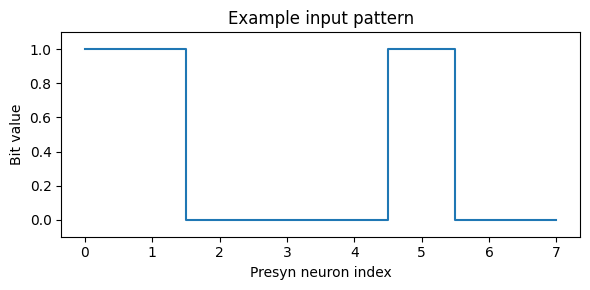

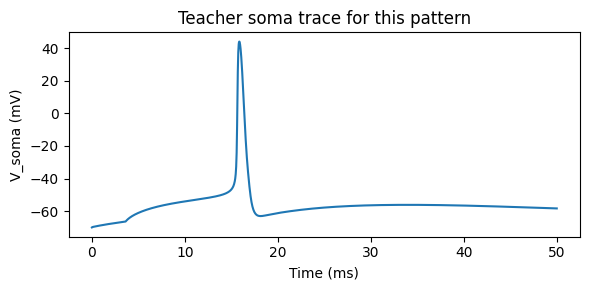

In [34]:
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [35]:
print("patterns shape:", patterns.shape)

for bad_idx in [200, 500, 10_000]:
    try:
        _ = patterns[bad_idx]
        print(f"Index {bad_idx} unexpectedly succeeded")
    except Exception as e:
        print(f"Index {bad_idx} raised: {repr(e)}")


patterns shape: (200, 8)
Index 200 unexpectedly succeeded
Index 500 unexpectedly succeeded
Index 10000 unexpectedly succeeded


OUT OF BOUNDS IS CLAMPED INTERNALLY? DEFAULTS TO LAST VALUE AKA IDX = 199

pattern_example shape: (8,)


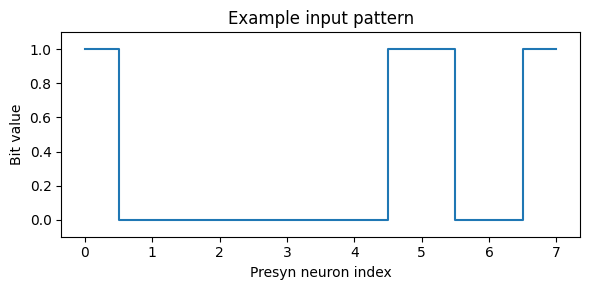

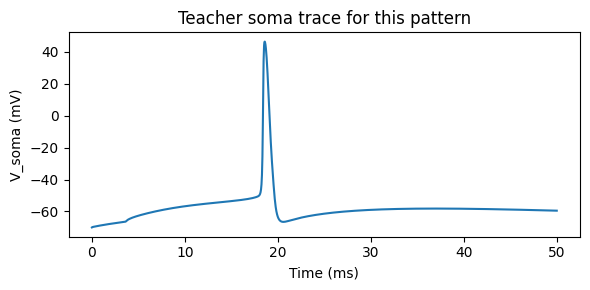

In [36]:
idx = 500
pattern_example = patterns[idx]
target_example  = targets[idx]   # shape (T,)
print("pattern_example shape:", pattern_example.shape)

# time axis from dt and T
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [37]:
print("patterns[195]:", patterns[195])
print("patterns[196]:", patterns[196])
print("patterns[197]:", patterns[197])
print("patterns[198]:", patterns[198])

patterns[195]: [0. 0. 1. 0. 0. 1. 1. 0.]
patterns[196]: [0. 1. 1. 1. 1. 1. 1. 1.]
patterns[197]: [0. 1. 1. 1. 0. 0. 1. 0.]
patterns[198]: [1. 0. 1. 1. 1. 1. 1. 1.]


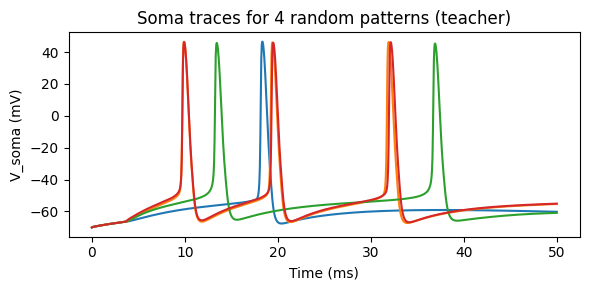

In [38]:
# run a small batch
traces = batched_simulate(params_true, patterns[195:199])  # (4, T)

T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces.T)   # traces.T has shape (T, 4)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces for 4 random patterns (teacher)")
plt.tight_layout()
plt.show()


In [39]:
traces = batched_simulate(params_true, patterns[196:199])
max_diff = np.max(np.abs(traces[0] - traces[2]))
print("max |difference| between trace 0 and 1:", float(max_diff))


max |difference| between trace 0 and 1: 80.08121191649411


In [40]:
traces = batched_simulate(params_true, patterns[196:197])  # indices 196,197,198
max_diff = np.max(np.abs(traces[0] - traces[4])) 
print("max |difference| between trace 0 and 1:", float(max_diff))         # 196 vs 197

pair = np.stack([patterns[196], patterns[198]], axis=0)   # shape (2, num_pre)
traces = batched_simulate(params_true, pair)              # shape (2, T)
max_diff = np.max(np.abs(traces[0] - traces[1]))
print("max |difference| between trace 0 and 1:", float(max_diff))

max |difference| between trace 0 and 1: 0.0
max |difference| between trace 0 and 1: 80.08121191649411


In [41]:
traces_batch = np.asarray(traces)   # make sure it's a NumPy array
n, T = traces_batch.shape

max_diffs = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        diff_ij = np.max(np.abs(traces_batch[i] - traces_batch[j]))
        max_diffs[i, j] = float(diff_ij)

print("pairwise max |difference|:")
print(max_diffs)

# Ignore self-comparisons
for i in range(n):
    max_diffs[i, i] = np.inf

# Find the closest pair
flat_idx = np.argmin(max_diffs)
i_min, j_min = divmod(flat_idx, n)

print(f"closest pair in this batch: {i_min} and {j_min}")
print(f"pattern indices in original array: {195 + i_min} and {195 + j_min}")
print(f"min max-diff: {max_diffs[i_min, j_min]:.6g}")


pairwise max |difference|:
[[ 0.         80.08121192]
 [80.08121192  0.        ]]
closest pair in this batch: 0 and 1
pattern indices in original array: 195 and 196
min max-diff: 80.0812


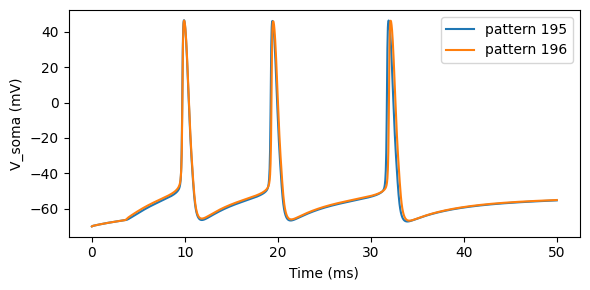

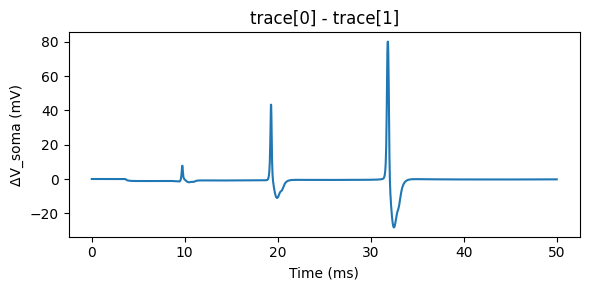

In [42]:
T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0], label="pattern 195")
ax.plot(time_vec, traces[1], label="pattern 196")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0] - traces[1])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ΔV_soma (mV)")
ax.set_title("trace[0] - trace[1]")
plt.tight_layout()
plt.show()


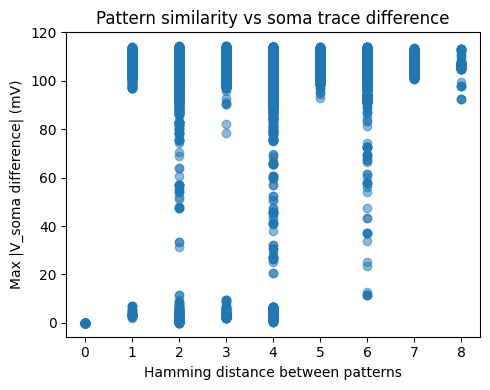

In [43]:
n_samples, num_pre = patterns.shape
_, T = targets.shape

# how many random pairs to sample
n_pairs = 100

rng = np.random.default_rng(0)

# sample random pairs (i, j), making sure i != j
idx_i = rng.integers(0, n_samples, size=n_pairs)
idx_j = rng.integers(0, n_samples, size=n_pairs)
mask = idx_i != idx_j
idx_i = idx_i[mask]
idx_j = idx_j[mask]

hamming_dists = []
max_diffs = []

for i in range(n_samples):
    for j in range(i+1, n_samples):
        h = int(np.sum(np.abs(patterns[i] - patterns[j])))
        d = float(np.max(np.abs(targets[i] - targets[j])))
        hamming_dists.append(h)
        max_diffs.append(d)

hamming_dists = np.array(hamming_dists)
max_diffs = np.array(max_diffs)

# scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(hamming_dists, max_diffs, alpha=0.5)
plt.xlabel("Hamming distance between patterns")
plt.ylabel("Max |V_soma difference| (mV)")
plt.title("Pattern similarity vs soma trace difference")
plt.tight_layout()
plt.show()


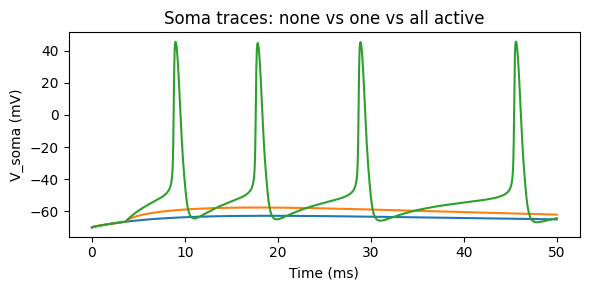

In [44]:
p_none = np.array([0, 0, 0, 0, 0.], dtype=np.float64)
p_one  = np.array([1, 0, 0, 0, 0.], dtype=np.float64)
p_all  = np.array([1, 1, 1, 1, 1.], dtype=np.float64)

ext_patterns = np.stack([p_none, p_one, p_all], axis=0)
ext_traces   = batched_simulate(params_true, ext_patterns)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, ext_traces.T)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces: none vs one vs all active")
plt.tight_layout()
plt.show()


SANITY DONE

TRAIN

In [45]:
key_learn = jax.random.PRNGKey(1)
noise_scale = 0.5

def add_noise_to_opt_params(opt_params, key, scale):
    leaves, treedef = jax.tree_util.tree_flatten(opt_params)
    subkeys = jax.random.split(key, len(leaves))
    noisy_leaves = [
        p + scale * jax.random.normal(k, p.shape)
        for p, k in zip(leaves, subkeys)
    ]
    return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)


In [46]:
print("opt_params_true:", opt_params_true)
print("opt_params_learn:", opt_params_learn)

opt_params_true: [{'IonotropicSynapse_gS': Array([-4.70048037, -4.70048037, -4.70048037, -4.70048037, -4.70048037,
       -4.70048037, -4.70048037, -4.70048037], dtype=float64)}]
opt_params_learn: [{'IonotropicSynapse_gS': Array([-4.15437057, -4.53451949, -5.15140135, -5.38955926, -4.48521748,
       -3.89707026, -4.6802116 , -5.09414458], dtype=float64)}]


In [47]:
def loss_fn(opt_params, patterns_batch, targets_batch):
    params = transform.forward(opt_params)
    preds = batched_simulate(params, patterns_batch)   # (B, T)
    return jnp.mean((preds - targets_batch) ** 2)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [48]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_params_learn)

num_steps = 500
print_every = 25

for step in range(num_steps + 1):
    train_loss, grads = grad_fn(opt_params_learn, patterns_train, targets_train)
    updates, opt_state = optimizer.update(grads, opt_state, opt_params_learn)
    opt_params_learn = optax.apply_updates(opt_params_learn, updates)

    if step % print_every == 0:
        val_loss = loss_fn(opt_params_learn, patterns_val, targets_val)
        print(f"step {step:4d} | train_loss={float(train_loss):.4e} "
              f"| val_loss={float(val_loss):.4e}")


step    0 | train_loss=4.8288e+02 | val_loss=4.9035e+02
step   25 | train_loss=2.8744e+02 | val_loss=3.4876e+02
step   50 | train_loss=2.7064e+02 | val_loss=3.2806e+02
step   75 | train_loss=2.5552e+02 | val_loss=3.1906e+02
step  100 | train_loss=2.4500e+02 | val_loss=3.0612e+02
step  125 | train_loss=2.4152e+02 | val_loss=3.0025e+02
step  150 | train_loss=2.4116e+02 | val_loss=3.0477e+02
step  175 | train_loss=2.8987e+02 | val_loss=3.3437e+02
step  200 | train_loss=2.6012e+02 | val_loss=3.3739e+02
step  225 | train_loss=2.6615e+02 | val_loss=3.3582e+02
step  250 | train_loss=2.6021e+02 | val_loss=3.2616e+02
step  275 | train_loss=2.5517e+02 | val_loss=3.2484e+02
step  300 | train_loss=2.5078e+02 | val_loss=3.2271e+02
step  325 | train_loss=2.4943e+02 | val_loss=3.2189e+02
step  350 | train_loss=2.5001e+02 | val_loss=3.2080e+02
step  375 | train_loss=2.4922e+02 | val_loss=3.2038e+02
step  400 | train_loss=2.4935e+02 | val_loss=3.2018e+02
step  425 | train_loss=2.4731e+02 | val_loss=3.1

In [49]:
train_loss_true = loss_fn(opt_params_true, patterns_train, targets_train)
val_loss_true   = loss_fn(opt_params_true, patterns_val, targets_val)
print("teacher train/val:", float(train_loss_true), float(val_loss_true))


teacher train/val: 0.0 0.0


In [50]:
params_learn_phys = transform.forward(opt_params_learn)
gS_true  = params_true[0]["IonotropicSynapse_gS"]
gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]

print("gS_true:",  gS_true)
print("gS_learn:", gS_learn)
print("max |diff|:", float(jnp.max(jnp.abs(gS_true - gS_learn))))


gS_true: [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
gS_learn: [1.36588004e-04 9.67181356e-05 7.05269093e-05 6.74155781e-05
 8.45793886e-05 1.50301465e-04 8.35361014e-05 7.84222307e-05]
max |diff|: 5.030146524988158e-05


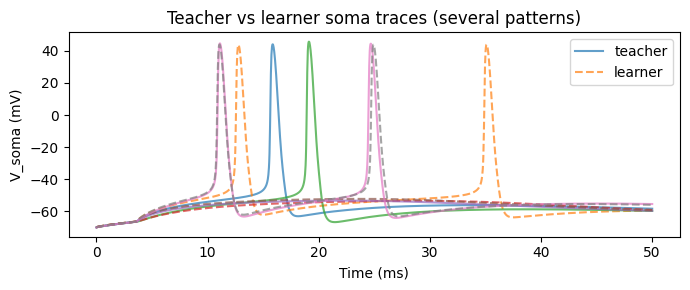

In [51]:
idxs = np.array([0, 1, 2, 3])  # any 4 indices < patterns_val.shape[0]

patterns_ex = patterns_train[idxs]       # (4, n_pre)
targets_ex  = targets_train[idxs]        # (4, T)


params_learn = transform.forward(opt_params_learn)


preds_ex = batched_simulate(params_learn, patterns_ex)   # (4, T)

T_ex = preds_ex.shape[1]
time_vec = np.arange(T_ex) * dt

plt.figure(figsize=(7, 3))
for i in range(len(idxs)):
    plt.plot(time_vec, targets_ex[i],       alpha=0.7, label="teacher" if i == 0 else None)
    plt.plot(time_vec, preds_ex[i], "--",   alpha=0.7, label="learner" if i == 0 else None)

plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs learner soma traces (several patterns)")
plt.legend()
plt.tight_layout()
plt.show()


GRADIENTS!

In [52]:
params_learn_phys = transform.forward(opt_params_learn)

In [53]:
def single_loss_phys(params_phys, pattern, target_trace):
    pred = simulate(params_phys, pattern)   # uses params_phys directly now
    return jnp.mean((pred - target_trace) ** 2)


In [54]:
idx = 0 
pattern_ex = patterns_train[idx]
target_ex  = targets_train[idx]    

loss_val, grads_phys = value_and_grad(single_loss_phys)(
    params_learn_phys, pattern_ex, target_ex
)

print("single-example loss:", float(loss_val))

# gradient wrt synaptic conductances
gS_grad = grads_phys[0]["IonotropicSynapse_gS"]   # ndarray
print("gS_grad shape:", gS_grad.shape)
print("gS_grad (first few):", gS_grad[:10])

gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]
print("gS_learn shape:", gS_learn.shape)
print("gS_learn (first few):", gS_learn[:10])


single-example loss: 404.4535115038693
gS_grad shape: (8,)
gS_grad (first few): [-96848.12802876 -58268.19202158  -4341.54115203   -414.72755508
   1590.58383987   3091.00857821   2566.75662408   2583.35351428]
gS_learn shape: (8,)
gS_learn (first few): [1.36588004e-04 9.67181356e-05 7.05269093e-05 6.74155781e-05
 8.45793886e-05 1.50301465e-04 8.35361014e-05 7.84222307e-05]


In [55]:
single_grad_phys = jax.grad(single_loss_phys, argnums=0)

grads_phys_train = vmap(
    single_grad_phys,
    in_axes=(None, 0, 0),    # params shared, patterns/targets batched
)(params_learn_phys, patterns_train, targets_train)

gS_grad_train = grads_phys_train[0]["IonotropicSynapse_gS"]   # shape (N_val, 8)
print("gS_grad_val shape:", gS_grad_train.shape)  # (N_val, 8)
print("first pattern grad:", gS_grad_train[0])

gS_grad_val shape: (160, 8)
first pattern grad: [-96848.12801082 -58268.1920049   -4341.54114896   -414.72755243
   1590.58384213   3091.00858701   2566.75662587   2583.35351601]


In [56]:
print("gS_grad_train (first 5 rows):\n", np.array(gS_grad_train[:5]))


gS_grad_train (first 5 rows):
 [[-9.68481280e+04 -5.82681920e+04 -4.34154115e+03 -4.14727552e+02
   1.59058384e+03  3.09100859e+03  2.56675663e+03  2.58335352e+03]
 [ 3.75738550e+05  1.81292896e+06  3.61900446e+05  1.72194317e+06
   3.41152961e+05  3.32380245e+05  3.25874500e+05  1.56807367e+06]
 [ 3.41262001e+05  6.54567618e+04  2.86376963e+05  5.29028235e+04
   4.76091113e+04  4.34639706e+04  4.09272401e+04  3.97940077e+04]
 [-2.57929529e+07 -2.35752775e+07 -4.17018642e+06 -1.60160908e+07
  -1.27704192e+07 -2.34154207e+06 -8.94060859e+06 -1.93217920e+06]
 [ 1.03136877e+05  5.52094542e+05  5.57824013e+05  5.50479221e+05
   5.35154293e+05  1.03005761e+05  5.06920129e+05  9.94334841e+04]]


In [57]:
for n in range(5):
    print(f"pattern {n} bits:", patterns_train[n])
    print(f"gS_grad_train[{n}]:", gS_grad_train[n])
    print()


pattern 0 bits: [1. 1. 0. 0. 0. 1. 0. 0.]
gS_grad_train[0]: [-96848.12801082 -58268.1920049   -4341.54114896   -414.72755243
   1590.58384213   3091.00858701   2566.75662587   2583.35351601]

pattern 1 bits: [0. 1. 0. 1. 0. 0. 0. 1.]
gS_grad_train[1]: [ 375738.55046608 1812928.96202575  361900.4461057  1721943.16698513
  341152.96060962  332380.24522925  325874.50041939 1568073.67419256]

pattern 2 bits: [1. 0. 1. 0. 0. 0. 0. 0.]
gS_grad_train[2]: [341262.00087806  65456.76175691 286376.96318173  52902.82348165
  47609.11132263  43463.970618    40927.24009077  39794.00773936]

pattern 3 bits: [1. 1. 0. 1. 1. 0. 1. 0.]
gS_grad_train[3]: [-25792952.90084643 -23575277.543972    -4170186.42242115
 -16016090.75690509 -12770419.15222083  -2341542.06539258
  -8940608.59218851  -1932179.1955878 ]

pattern 4 bits: [0. 1. 1. 1. 1. 0. 1. 0.]
gS_grad_train[4]: [103136.87719709 552094.54168132 557824.01258951 550479.22125784
 535154.29315573 103005.76132106 506920.12884442  99433.48405628]



In [58]:
row_norms = jnp.linalg.norm(gS_grad_train, axis=1)
print("first 10 row norms:", row_norms[:10])


first 10 row norms: [  113221.5055686   3052189.75336513   461485.8187775  41799640.80661158
  1222086.71524485 32645462.84543474 22734701.10723355 30092642.92385429
 43963528.71233069   117012.79234626]


DEFINE BIOPHYSICAL CORRELATES TO LOOK AT

In [59]:
# ===================================================================
# STEP 0 — Define canonical synapse index
# ===================================================================
# syn_post_comp_indices[i] = local compartment index on the post cell
# where synapse i was connected.  Gradient gS_grad[i] refers to the
# same synapse i (parameters are stored in edge-creation order).

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
Nsyn = len(syn_post_comp_indices)

print(f"Nsyn = {Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")
print()

# Print alignment table
print(f"{'syn_i':>5} | {'pre_cell':>8} | {'post_comp_local':>15} | {'post_comp_global':>16}")
print("-" * 55)
for i in range(Nsyn):
    local_c = syn_post_comp_indices[i]
    global_c = num_pre + local_c   # post cell comps start at global index num_pre
    print(f"{i:>5} | {i:>8} | {local_c:>15} | {global_c:>16}")

# Cross-check: for pattern 0 = [1,1,0,0,0,1,0,0], active pre cells
# are 0,1,5 → largest gradients should be at synapses 0,1,5
print("\nQuick alignment check (pattern 0):")
print(f"  bits       = {np.array(patterns_train[0])}")
print(f"  |grad_w|   = {np.abs(np.array(gS_grad_train[0])).astype(int)}")
print(f"  active pre → largest |grad|?  ✓" 
      if np.argmax(np.abs(np.array(gS_grad_train[0]))) in np.where(np.array(patterns_train[0]) == 1)[0]
      else "  ✗ check ordering!")


Nsyn = 8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

syn_i | pre_cell | post_comp_local | post_comp_global
-------------------------------------------------------
    0 |        0 |               0 |                8
    1 |        1 |               2 |               10
    2 |        2 |               4 |               12
    3 |        3 |               6 |               14
    4 |        4 |               8 |               16
    5 |        5 |              10 |               18
    6 |        6 |              12 |               20
    7 |        7 |              14 |               22

Quick alignment check (pattern 0):
  bits       = [1. 1. 0. 0. 0. 1. 0. 0.]
  |grad_w|   = [96848 58268  4341   414  1590  3091  2566  2583]
  active pre → largest |grad|?  ✓


In [60]:
# ===================================================================
# STEP 1 — Build a fresh analysis network
# ===================================================================
def build_net():
    """Recreate the full network from scratch (identical topology to training net)."""
    _comp_pre  = jx.Compartment()
    _branch_pre = jx.Branch(_comp_pre, ncomp=1)
    _cell_pre  = jx.Cell(_branch_pre, parents=np.asarray([-1]))

    _comp_post  = jx.Compartment()
    _branch_post = jx.Branch(_comp_post, ncomp=n_post_comp)
    _cell_post  = jx.Cell(_branch_post, parents=np.asarray([-1]))

    _cells = [_cell_pre for _ in range(num_pre)] + [_cell_post]
    _net   = jx.Network(_cells)

    _net.insert(Na())
    _net.insert(K())
    _net.insert(Leak())

    _syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            _net.cell(pre_i).branch(0).comp(0),
            _net.cell(post_idx).branch(0).comp(int(comp_i)),
            _syn,
        )
    return _net

net_analysis = build_net()
print(f"net_analysis: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")


net_analysis: 23 compartments, 8 edges


In [61]:
# ===================================================================
# STEP 2 — Set up recordings & define simulate_analysis
# ===================================================================
#
# Jaxley deduplicates recordings on the same compartment, so we must
# NOT record comp 0 twice.  Synapse 0 lives at comp 0 (= soma).
# Strategy: record soma (comp 0) once, then the remaining synapse
# sites (comp != 0).  When unpacking traces we reconstruct V_local
# by assigning V_soma to synapse 0.
#
# Recording layout (Nsyn = 8 unique comps):
#   traces[0]       → comp 0  (soma / synapse 0)
#   traces[1..Nsyn-1] → comp 2,4,6,8,10,12,14  (synapses 1..7)
# Total recordings = Nsyn (= 8)

def setup_recordings_for_synapses(net_obj, post_cell_idx, comp_indices):
    """
    Record soma (comp 0) once, then every *other* synapse site.
    Returns (net_obj, list_of_non_soma_comp_indices).
    """
    net_obj.delete_recordings()
    # Record soma = comp 0  (also the site of synapse 0)
    net_obj.cell(post_cell_idx).branch(0).comp(0).record()
    # Record remaining synapse sites, skipping comp 0
    comp_indices_no0 = [ci for ci in comp_indices if int(ci) != 0]
    for ci in comp_indices_no0:
        net_obj.cell(post_cell_idx).branch(0).comp(int(ci)).record()
    return net_obj, comp_indices_no0

net_analysis, _syn_comp_no0 = setup_recordings_for_synapses(
    net_analysis, post_idx, syn_post_comp_indices
)

n_rec = 1 + len(_syn_comp_no0)          # should equal Nsyn
assert n_rec == Nsyn, f"Expected {Nsyn} recordings, got {n_rec}"

# Make trainable (same edge ordering as training net)
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

# Reuse the same transform; apply learned weights
params_analysis = transform.forward(opt_params_learn)

print(f"Recordings: 1 (soma/syn0) + {len(_syn_comp_no0)} (syn 1‥{Nsyn-1}) "
      f"= {n_rec} unique")
print(f"Learned gS: {params_analysis[0]['IonotropicSynapse_gS']}")

# ---------- simulate_analysis ----------
def simulate_analysis(params_phys, pattern):
    """Run analysis net → all recordings shape (Nsyn, T).

    Layout:
      traces[0]       = comp 0  (soma / synapse 0)
      traces[1:Nsyn]  = comp 2,4,…,14  (synapses 1‥7)
    """
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    return jx.integrate(
        net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )

def unpack_traces(traces):
    """
    Unpack raw recordings → (V_soma, V_local).

    traces : (Nsyn, T)  from simulate_analysis
    Returns
    -------
    V_soma  : (T,)
    V_local : (Nsyn, T)  — V_local[i] = voltage at synapse i's site
    """
    V_soma = traces[0]                       # comp 0
    # Build V_local: synapse 0 → soma, synapses 1‥Nsyn-1 → traces[1:]
    V_local = jnp.concatenate(
        [traces[0:1], traces[1:]],           # [soma, syn1, syn2, …, syn7]
        axis=0,
    )                                        # (Nsyn, T)
    return V_soma, V_local


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Recordings: 1 (soma/syn0) + 7 (syn 1‥7) = 8 unique
Learned gS: [1.36588004e-04 9.67181356e-05 7.05269093e-05 6.74155781e-05
 8.45793886e-05 1.50301465e-04 8.35361014e-05 7.84222307e-05]


Raw traces shape: (8, 2002)  (expect (8, ~2002))
V_soma  shape: (2002,)
V_local shape: (8, 2002)  (expect (8, T))


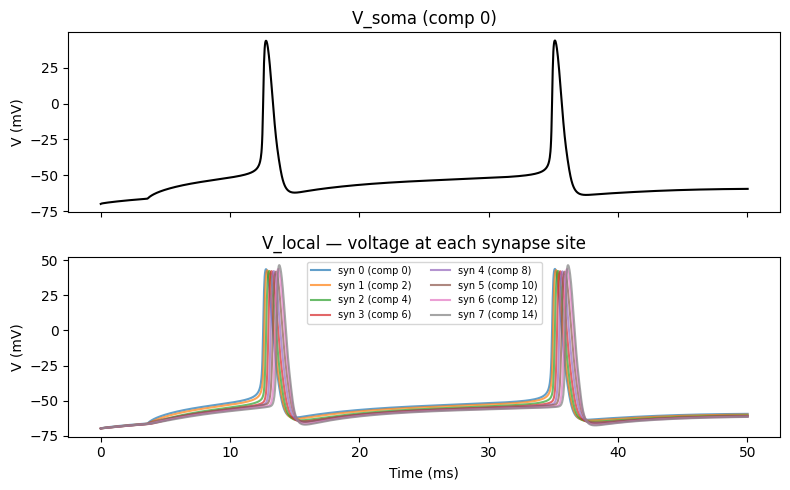

Sanity — max |V_soma − V_local[syn0]|: 0.00e+00  (should be 0.0)


In [62]:
# ===== Step 2 deliverable — verify recordings with one trial =====
_test_traces = simulate_analysis(params_analysis, patterns_train[0])
print(f"Raw traces shape: {_test_traces.shape}  (expect ({Nsyn}, ~2002))")
assert _test_traces.shape[0] == Nsyn, \
    f"Expected {Nsyn} recordings, got {_test_traces.shape[0]}"

# Unpack into V_soma and V_local (synapse 0 → soma copy)
_V_soma, _V_local = unpack_traces(_test_traces)
print(f"V_soma  shape: {_V_soma.shape}")
print(f"V_local shape: {_V_local.shape}  (expect ({Nsyn}, T))")

_T = _test_traces.shape[1]
_tv = np.arange(_T) * dt

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

axes[0].plot(_tv, _V_soma, "k", lw=1.5)
axes[0].set_ylabel("V (mV)")
axes[0].set_title("V_soma (comp 0)")

for i in range(Nsyn):
    axes[1].plot(_tv, _V_local[i], alpha=0.7,
                 label=f"syn {i} (comp {syn_post_comp_indices[i]})")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("V (mV)")
axes[1].set_title("V_local — voltage at each synapse site")
axes[1].legend(fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

# Sanity: synapse 0 is at comp 0 = soma, so V_local[0] == V_soma exactly
print(f"Sanity — max |V_soma − V_local[syn0]|: "
      f"{float(jnp.max(jnp.abs(_V_soma - _V_local[0]))):.2e}  (should be 0.0)")


In [63]:
# ===================================================================
# STEP 3 — One trial → (grad_w, V_soma, V_local)
# ===================================================================

def loss_and_traces(params_phys, pattern, target):
    """
    Returns (scalar_loss, raw_traces).
    has_aux=True tells JAX to differentiate only the loss,
    while carrying raw_traces as auxiliary output.

    raw_traces shape: (Nsyn, T)
      [0]      = comp 0  (soma / syn 0)
      [1:Nsyn] = comp 2,4,…,14  (syn 1‥7)
    """
    raw_traces = simulate_analysis(params_phys, pattern)   # (Nsyn, T)
    soma_pred  = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    """
    Returns
    -------
    grad_w  : (Nsyn,)     ∂L/∂gS for each synapse
    V_soma  : (T,)        soma voltage
    V_local : (Nsyn, T)   local voltage at each synapse site
    loss    : scalar
    """
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    V_soma, V_local = unpack_traces(raw_traces)     # (T,), (Nsyn, T)
    return grad_w, V_soma, V_local, loss

# ===== Step 3 deliverable — test on first training example =====
gw, vs, vl, lo = single_trial(params_analysis, patterns_train[0], targets_train[0])
print(f"grad_w  shape: {gw.shape}  (expect ({Nsyn},))")
print(f"V_soma  shape: {vs.shape}")
print(f"V_local shape: {vl.shape}  (expect ({Nsyn}, T))")
print(f"loss = {float(lo):.4f}")
print(f"grad_w = {gw}")

# Cross-check against gradients computed earlier (cell 61)
print(f"\nEarlier gS_grad_train[0] = {gS_grad_train[0]}")
print(f"Max |diff| = {float(jnp.max(jnp.abs(gw - gS_grad_train[0]))):.2e}")


grad_w  shape: (8,)  (expect (8,))
V_soma  shape: (2002,)
V_local shape: (8, 2002)  (expect (8, T))
loss = 404.4535
grad_w = [-96848.12802876 -58268.19202158  -4341.54115203   -414.72755508
   1590.58383987   3091.00857821   2566.75662408   2583.35351428]

Earlier gS_grad_train[0] = [-96848.12801082 -58268.1920049   -4341.54114896   -414.72755243
   1590.58384213   3091.00858701   2566.75662587   2583.35351601]
Max |diff| = 1.79e-05


In [64]:
# ===================================================================
# STEP 4 — Extract local physiology for N trials & save
# ===================================================================
N_trials = 500
key_data = jax.random.PRNGKey(42)

# Fresh random binary patterns
patterns_data = jax.random.bernoulli(
    key_data, p=0.5, shape=(N_trials, num_pre)
).astype(jnp.float64)

# Teacher targets (true params, original net)
targets_data = batched_simulate(params_true, patterns_data)   # (N, T)

print(f"patterns_data : {patterns_data.shape}")
print(f"targets_data  : {targets_data.shape}")


patterns_data : (500, 8)
targets_data  : (500, 2002)


In [65]:
# Batched extraction: vmap value_and_grad over all trials
_batched_vg = jit(
    jax.vmap(
        jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
        in_axes=(None, 0, 0),
    )
)

print(f"Running batched extraction for {N_trials} trials "
      f"(first call includes JIT compilation) …")
((losses_all, raw_traces_all), grads_all) = _batched_vg(
    params_analysis, patterns_data, targets_data
)
# raw_traces_all shape: (N, Nsyn, T)
#   [:, 0, :]      = comp 0  (soma / synapse 0)
#   [:, 1:Nsyn, :] = comp 2,4,…,14  (synapses 1‥7)

# Unpack into numpy arrays
GRADS  = np.asarray(grads_all[0]["IonotropicSynapse_gS"])     # (N, Nsyn)
VSOMA  = np.asarray(raw_traces_all[:, 0, :])                   # (N, T)
# Reconstruct V_local: syn 0 → soma, syn 1‥7 → traces[1:]
VLOCAL = np.concatenate(
    [np.asarray(raw_traces_all[:, 0:1, :]),                    # syn 0 = soma
     np.asarray(raw_traces_all[:, 1:, :])],                    # syn 1‥7
    axis=1,
)                                                               # (N, Nsyn, T)
LOSSES = np.asarray(losses_all)                                 # (N,)

print(f"\nGRADS  : {GRADS.shape}")
print(f"VSOMA  : {VSOMA.shape}")
print(f"VLOCAL : {VLOCAL.shape}")
print(f"LOSSES : min={LOSSES.min():.1f}  mean={LOSSES.mean():.1f}  max={LOSSES.max():.1f}")

# Quick sanity: V_local[:, 0, :] should equal V_soma
print(f"Sanity — max |VSOMA − VLOCAL[:,0,:]|: "
      f"{np.max(np.abs(VSOMA - VLOCAL[:, 0, :])):.2e}  (should be 0.0)")


Running batched extraction for 500 trials (first call includes JIT compilation) …

GRADS  : (500, 8)
VSOMA  : (500, 2002)
VLOCAL : (500, 8, 2002)
LOSSES : min=0.0  mean=265.5  max=739.3
Sanity — max |VSOMA − VLOCAL[:,0,:]|: 0.00e+00  (should be 0.0)


In [66]:
# Save to disk
import os

save_dir  = "/n/home12/isanchez/jaxneuro/outputs"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "local_phys_dataset.npz")

np.savez(
    save_path,
    GRADS=GRADS,
    VSOMA=VSOMA,
    VLOCAL=VLOCAL,
    patterns=np.asarray(patterns_data),
    losses=LOSSES,
    syn_post_comp_indices=np.asarray(syn_post_comp_indices),
    dt=dt,
    t_max=t_max,
    i_delay=i_delay,
    i_dur=i_dur,
    N_trials=N_trials,
    Nsyn=Nsyn,
)

fsize = os.path.getsize(save_path)
print(f"Saved → {save_path}  ({fsize / 1e6:.1f} MB)")


Saved → /n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz  (72.1 MB)


# ═══════════════════════════════════════════════════════════════════
# ANALYSIS — Correlation between local physiology and credit signals
# ═══════════════════════════════════════════════════════════════════


## Deliverable 0 — Reproducible loader + metadata


In [67]:
# ===================================================================
# Deliverable 0 — Reproducible loader + metadata
# ===================================================================
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    """Load the local-physiology dataset and return a dict with all arrays + metadata."""
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    # Scalar metadata come back as 0-d arrays — unwrap them
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

# Unpack main arrays
GRADS  = ds["GRADS"]          # (N, Nsyn)
VLOCAL = ds["VLOCAL"]         # (N, Nsyn, T)
VSOMA  = ds["VSOMA"]          # (N, T)
patterns = ds["patterns"]     # (N, Nsyn)
losses = ds["losses"]         # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt      = ds["dt"]
t_max   = ds["t_max"]
i_delay = ds["i_delay"]
i_dur   = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VLOCAL.shape[2]

# Time axis
t = np.arange(T) * dt  # (T,)

# Stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)

# ---- Shape checks ----
print("=== Shape checks ===")
print(f"  GRADS    : {GRADS.shape}    (expect ({N}, {Nsyn}))")
print(f"  VLOCAL   : {VLOCAL.shape}  (expect ({N}, {Nsyn}, {T}))")
print(f"  VSOMA    : {VSOMA.shape}   (expect ({N}, {T}))")
print(f"  patterns : {patterns.shape}")
print(f"  losses   : {losses.shape}")
print(f"\n  dt={dt} ms,  t_max={t_max} ms,  T={T} timepoints")
print(f"  i_delay={i_delay} ms,  i_dur={i_dur} ms")
print(f"  stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f"  N_trials={N},  Nsyn={Nsyn}")
print(f"  syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape  == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn, T)
assert VSOMA.shape  == (N, T)
print("\n✓ All shape checks passed.")


=== Shape checks ===
  GRADS    : (500, 8)    (expect (500, 8))
  VLOCAL   : (500, 8, 2002)  (expect (500, 8, 2002))
  VSOMA    : (500, 2002)   (expect (500, 2002))
  patterns : (500, 8)
  losses   : (500,)

  dt=0.025 ms,  t_max=50.0 ms,  T=2002 timepoints
  i_delay=3.0 ms,  i_dur=2.0 ms
  stimulus window: 81 timepoints (3.000–5.000 ms)
  N_trials=500,  Nsyn=8
  syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

✓ All shape checks passed.


## Step A — Time-resolved correlation map

At each timepoint $t$, compute the Pearson correlation (across trials $n$) between the local signal $x_{n,i}(t)$ and the gradient $g_{n,i}$:

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

Then aggregate: $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$.


In [68]:
# ===================================================================
# Deliverable A1 — Time-resolved correlation curves
# ===================================================================

def time_resolved_corr(signal, grads):
    """
    Compute per-synapse, per-timepoint Pearson r between a time-varying
    signal and the (scalar) gradient across trials.

    Parameters
    ----------
    signal : (N, Nsyn, T)   local physiological signal
    grads  : (N, Nsyn)      trial-level gradient for each synapse

    Returns
    -------
    r_by_syn : (Nsyn, T)    Pearson r for each synapse × timepoint
    """
    N, Nsyn, T = signal.shape
    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i]                       # (N,)
        # Vectorised Pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]                     # (N, T)
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num   = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30
        r_by_syn[i] = num / denom
    return r_by_syn

# ---- Signal 1: V_local ----
r_vlocal = time_resolved_corr(VLOCAL, GRADS)          # (Nsyn, T)
mean_r2_vlocal = (r_vlocal**2).mean(axis=0)            # (T,)
mean_r_vlocal  = r_vlocal.mean(axis=0)                 # (T,)

# ---- Signal 2: dV/dt (finite difference of V_local along time) ----
dVdt = np.gradient(VLOCAL, dt, axis=2)                  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS)                # (Nsyn, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0)                 # (T,)
mean_r_dvdt  = r_dvdt.mean(axis=0)                      # (T,)

print(f"r_vlocal shape: {r_vlocal.shape}  (Nsyn, T)")
print(f"mean_r2_vlocal shape: {mean_r2_vlocal.shape}  (T,)")
print(f"r_dvdt shape:   {r_dvdt.shape}")
print(f"mean_r2_dvdt shape:   {mean_r2_dvdt.shape}")


r_vlocal shape: (8, 2002)  (Nsyn, T)
mean_r2_vlocal shape: (2002,)  (T,)
r_dvdt shape:   (8, 2002)
mean_r2_dvdt shape:   (2002,)


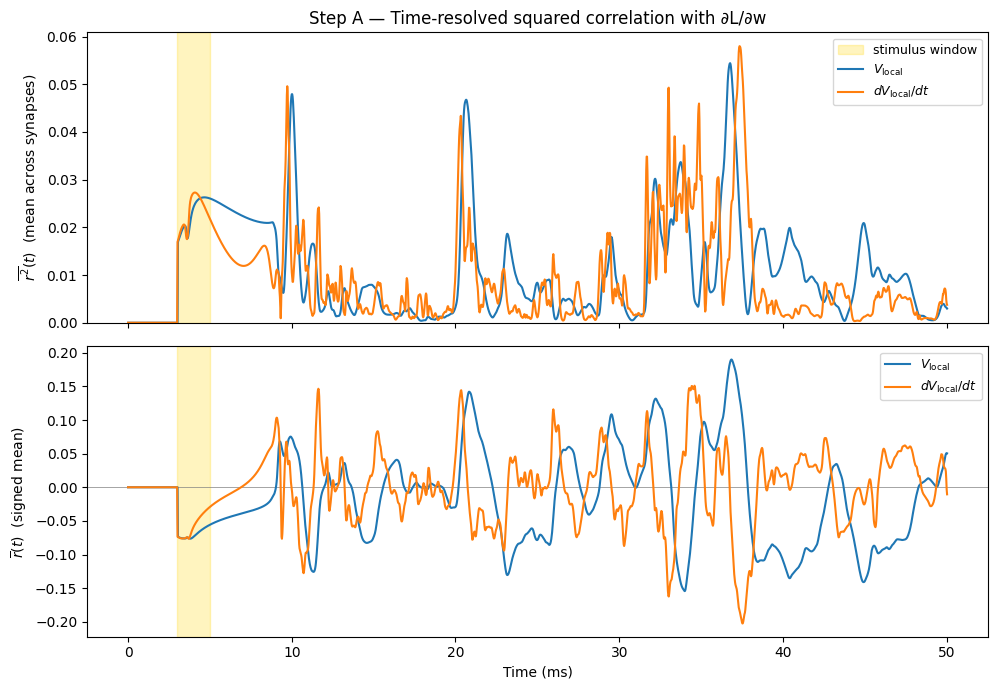

In [69]:
# ---- Plot: mean r² over time for each signal, stimulus window shaded ----
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# --- Panel 1: mean r²(t) ---
ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("Step A — Time-resolved squared correlation with ∂L/∂w")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

# --- Panel 2: mean r(t) (signed) ---
ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


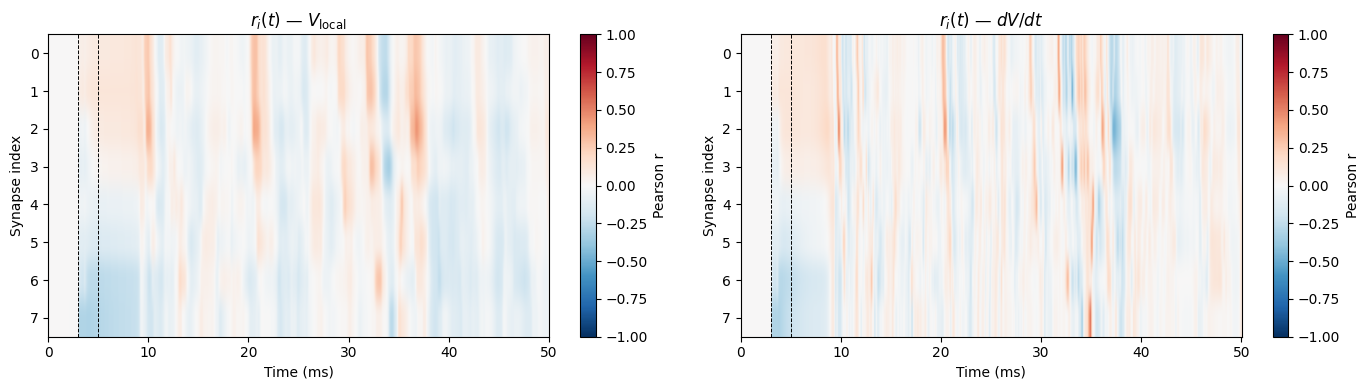

In [70]:
# ---- Per-synapse r(t) heatmaps ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, data, title in zip(
    axes,
    [r_vlocal, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm local}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r", vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()


In [71]:
# ---- Save Step A arrays ----
save_A = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_stepA.npz")
np.savez(
    save_A,
    r_vlocal=r_vlocal,          # (Nsyn, T)
    mean_r2_vlocal=mean_r2_vlocal,  # (T,)
    mean_r_vlocal=mean_r_vlocal,
    r_dvdt=r_dvdt,
    mean_r2_dvdt=mean_r2_dvdt,
    mean_r_dvdt=mean_r_dvdt,
    t=t,
)
print(f"✓ Step A saved → {save_A}  ({os.path.getsize(save_A)/1e3:.1f} kB)")


✓ Step A saved → /n/home12/isanchez/jaxneuro/outputs/analysis_stepA.npz  (338.1 kB)


## Step B — Baseline hand-picked window features

### B1 — Feature extraction

For each trial $n$ and synapse $i$ we compute a small bank of interpretable features from fixed time windows (stimulus window, post-spike window).


In [72]:
# ===================================================================
# Deliverable B1 — Feature extraction for a small feature bank
# ===================================================================

# # Compute dV/dt here so this cell is self-contained
# # (also computed in Step A, but we don't require that cell to run first)
# dVdt = np.gradient(VLOCAL, dt, axis=2)   # (N, Nsyn, T)

# -------------------------------------------------------------------
# 1. Stimulus-window features  (computed from VLOCAL and dVdt)
# -------------------------------------------------------------------
stim_mask = t_stim  # boolean (T,)

# Slices of the signals inside the stimulus window
V_stim  = VLOCAL[:, :, stim_mask]          # (N, Nsyn, T_stim)
dV_stim = dVdt[:, :, stim_mask]            # (N, Nsyn, T_stim)

mean_V_stim   = V_stim.mean(axis=2)       # (N, Nsyn)
peak_V_stim   = V_stim.max(axis=2)        # (N, Nsyn)
auc_V_stim    = V_stim.sum(axis=2) * dt   # (N, Nsyn) — integral approximation
max_dVdt_stim = dV_stim.max(axis=2)       # (N, Nsyn)
min_dVdt_stim = dV_stim.min(axis=2)       # (N, Nsyn)

print(f"Stimulus window: {stim_mask.sum()} timepoints, "
      f"V_stim shape {V_stim.shape}")

# -------------------------------------------------------------------
# 2. bAP-proxy / spike-locked features
# -------------------------------------------------------------------
# Detect soma spike times via threshold crossing on VSOMA
spike_threshold = 0.0  # mV  (generous for HH spikes that peak ~+40 mV)
bap_window_ms   = 3.0  # ms after soma spike to look for local peak
bap_window_pts  = int(bap_window_ms / dt)

def detect_spikes(v_soma, threshold=0.0):
    """Return indices of upward threshold crossings."""
    above = v_soma > threshold
    crossings = np.where(np.diff(above.astype(int)) == 1)[0]
    return crossings  # indices into time axis

# For each trial, detect spike times and extract bAP features
bap_peak_local  = np.full((N, Nsyn), np.nan)   # max V in post-spike window
bap_amp_local   = np.full((N, Nsyn), np.nan)   # peak − pre-spike baseline

for n in range(N):
    spk_idx = detect_spikes(VSOMA[n], spike_threshold)
    if len(spk_idx) == 0:
        continue
    # Use only the FIRST spike (simplest proxy)
    s0 = spk_idx[0]
    s1 = min(s0 + bap_window_pts, T)
    # Baseline: mean V in 1 ms before spike
    bl_start = max(0, s0 - int(1.0 / dt))
    for i in range(Nsyn):
        v_win = VLOCAL[n, i, s0:s1]
        if len(v_win) == 0:
            continue
        pk = v_win.max()
        bl = VLOCAL[n, i, bl_start:s0].mean() if s0 > bl_start else VLOCAL[n, i, 0]
        bap_peak_local[n, i] = pk
        bap_amp_local[n, i]  = pk - bl

n_spikes_detected = np.sum(~np.isnan(bap_peak_local[:, 0]))
print(f"Trials with ≥1 soma spike: {n_spikes_detected}/{N}")

# Explicit indicator: did this trial have a spike?  (broadcast to all synapses)
spiked = (~np.isnan(bap_peak_local[:, 0])).astype(float)[:, None]  # (N, 1)
spiked = np.repeat(spiked, Nsyn, axis=1)                           # (N, Nsyn)

# -------------------------------------------------------------------
# 3. Assemble feature matrix  X (N*Nsyn, n_features), y (N*Nsyn,)
# -------------------------------------------------------------------
feature_dict = {
    "mean_V_stim":    mean_V_stim,       # (N, Nsyn)
    "peak_V_stim":    peak_V_stim,
    "auc_V_stim":     auc_V_stim,
    "max_dVdt_stim":  max_dVdt_stim,
    "min_dVdt_stim":  min_dVdt_stim,
    "bap_peak_local": bap_peak_local,
    "bap_amp_local":  bap_amp_local,
    "spiked":         spiked,            # binary indicator — spike present
}

feature_names = list(feature_dict.keys())
n_features = len(feature_names)

# Stack into (N, Nsyn, n_features) then reshape
feature_stack = np.stack([feature_dict[fn] for fn in feature_names], axis=-1)  # (N, Nsyn, F)
X_raw = feature_stack.reshape(N * Nsyn, n_features)                            # (N*Nsyn, F)
y = GRADS.reshape(-1)                                                          # (N*Nsyn,)

# Handle NaNs from trials without spikes: impute with column median
from numpy import nanmedian
for col in range(n_features):
    mask_nan = np.isnan(X_raw[:, col])
    if mask_nan.any():
        X_raw[mask_nan, col] = nanmedian(X_raw[:, col])

X = X_raw.copy()

print(f"\nFeature matrix X shape: {X.shape}  (N*Nsyn, n_features)")
print(f"Target vector  y shape: {y.shape}")
print(f"Features: {feature_names}")

# Save
save_B1 = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "features_baseline.npz")
np.savez(
    save_B1,
    X=X, y=y,
    feature_names=np.array(feature_names),
    N=N, Nsyn=Nsyn,
    stim_mask=stim_mask,
    bap_window_ms=bap_window_ms,
    spike_threshold=spike_threshold,
)
print(f"✓ Saved → {save_B1}  ({os.path.getsize(save_B1)/1e3:.1f} kB)")


Stimulus window: 81 timepoints, V_stim shape (500, 8, 81)
Trials with ≥1 soma spike: 413/500

Feature matrix X shape: (4000, 8)  (N*Nsyn, n_features)
Target vector  y shape: (4000,)
Features: ['mean_V_stim', 'peak_V_stim', 'auc_V_stim', 'max_dVdt_stim', 'min_dVdt_stim', 'bap_peak_local', 'bap_amp_local', 'spiked']
✓ Saved → /n/home12/isanchez/jaxneuro/outputs/features_baseline.npz  (292.5 kB)


### B2 — Baseline predictive performance (CV)

We use **trial-split** cross-validation: folds split by trial index so that all synapses from one trial are either in train or test (never mixed). This prevents information leakage via shared trial-level confounds.

- **Ridge regression** → predict gradient magnitude → report CV $R^2$ and Pearson $r$
- **Logistic regression** → predict sign of gradient → report accuracy and AUROC


In [73]:
# ===================================================================
# Deliverable B2 — Baseline predictive performance (CV)
# ===================================================================
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (r2_score, roc_auc_score, accuracy_score,
                             balanced_accuracy_score)
from scipy.stats import pearsonr

n_folds = 5
n_inner_folds = 3   # for hyperparameter selection inside each outer fold

# Trial-level group labels: row k in X corresponds to trial k // Nsyn
trial_ids = np.repeat(np.arange(N), Nsyn)  # (N*Nsyn,)

gkf = GroupKFold(n_splits=n_folds)

# ---- Containers for fold-level metrics ----
ridge_r2_folds      = []
ridge_r_folds       = []
logistic_acc_folds  = []
logistic_bacc_folds = []   # balanced accuracy
logistic_auc_folds  = []
majority_acc_folds  = []   # majority-class baseline

# For one example fold we'll store predictions for plotting
best_fold_y_true = None
best_fold_y_pred = None

for fold_i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=trial_ids)):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # Standardise features (fit on train only)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # ---- Ridge regression (gradient magnitude) ----
    # Inner CV respects trial groups to avoid leakage
    inner_groups_tr = trial_ids[train_idx]
    ridge_gs = GridSearchCV(
        Ridge(),
        {"alpha": np.logspace(-2, 6, 50)},
        cv=GroupKFold(n_splits=n_inner_folds),
        scoring="r2",
    )
    ridge_gs.fit(X_tr_s, y_tr, groups=inner_groups_tr)
    y_pred_ridge = ridge_gs.predict(X_te_s)

    r2    = r2_score(y_te, y_pred_ridge)
    r_val = pearsonr(y_te, y_pred_ridge)[0]
    ridge_r2_folds.append(r2)
    ridge_r_folds.append(r_val)

    # Save first fold for plotting
    if fold_i == 0:
        best_fold_y_true = y_te
        best_fold_y_pred = y_pred_ridge

    # ---- Logistic regression (sign of gradient) ----
    y_sign_tr = (y_tr > 0).astype(int)
    y_sign_te = (y_te > 0).astype(int)

    # Majority-class baseline
    majority_class_frac = max(y_sign_te.mean(), 1 - y_sign_te.mean())
    majority_acc_folds.append(majority_class_frac)

    # Check there are both classes
    if len(np.unique(y_sign_tr)) > 1 and len(np.unique(y_sign_te)) > 1:
        logit_gs = GridSearchCV(
            LogisticRegression(max_iter=2000),
            {"C": np.logspace(-3, 3, 20)},
            cv=GroupKFold(n_splits=n_inner_folds),
            scoring="roc_auc",
        )
        logit_gs.fit(X_tr_s, y_sign_tr, groups=inner_groups_tr)
        y_prob = logit_gs.predict_proba(X_te_s)[:, 1]
        y_pred_sign = logit_gs.predict(X_te_s)
        acc  = accuracy_score(y_sign_te, y_pred_sign)
        bacc = balanced_accuracy_score(y_sign_te, y_pred_sign)
        auc  = roc_auc_score(y_sign_te, y_prob)
        logistic_acc_folds.append(acc)
        logistic_bacc_folds.append(bacc)
        logistic_auc_folds.append(auc)
    else:
        logistic_acc_folds.append(np.nan)
        logistic_bacc_folds.append(np.nan)
        logistic_auc_folds.append(np.nan)

    print(f"  Fold {fold_i}: Ridge R²={r2:.4f} r={r_val:.4f} | "
          f"Logistic bal_acc={logistic_bacc_folds[-1]:.4f} AUC={logistic_auc_folds[-1]:.4f} "
          f"(majority baseline acc={majority_class_frac:.4f})")

# ---- Summary ----
print("\n" + "=" * 70)
print("BASELINE METRICS  (mean +/- std across folds)")
print("=" * 70)
print(f"  Ridge R²            : {np.mean(ridge_r2_folds):.4f} +/- {np.std(ridge_r2_folds):.4f}")
print(f"  Ridge Pearson r     : {np.mean(ridge_r_folds):.4f} +/- {np.std(ridge_r_folds):.4f}")
print(f"  Logistic acc        : {np.nanmean(logistic_acc_folds):.4f} +/- {np.nanstd(logistic_acc_folds):.4f}")
print(f"  Logistic bal. acc   : {np.nanmean(logistic_bacc_folds):.4f} +/- {np.nanstd(logistic_bacc_folds):.4f}")
print(f"  Logistic AUROC      : {np.nanmean(logistic_auc_folds):.4f} +/- {np.nanstd(logistic_auc_folds):.4f}")
print(f"  Majority-class acc  : {np.mean(majority_acc_folds):.4f}  (dumb baseline)")

# Save metrics
baseline_metrics = {
    "ridge_r2_mean":  float(np.mean(ridge_r2_folds)),
    "ridge_r2_std":   float(np.std(ridge_r2_folds)),
    "ridge_r_mean":   float(np.mean(ridge_r_folds)),
    "ridge_r_std":    float(np.std(ridge_r_folds)),
    "logistic_acc_mean":  float(np.nanmean(logistic_acc_folds)),
    "logistic_acc_std":   float(np.nanstd(logistic_acc_folds)),
    "logistic_bacc_mean": float(np.nanmean(logistic_bacc_folds)),
    "logistic_bacc_std":  float(np.nanstd(logistic_bacc_folds)),
    "logistic_auc_mean":  float(np.nanmean(logistic_auc_folds)),
    "logistic_auc_std":   float(np.nanstd(logistic_auc_folds)),
    "majority_acc_mean":  float(np.mean(majority_acc_folds)),
    "n_folds": n_folds,
    "n_inner_folds": n_inner_folds,
    "feature_names": feature_names,
    "ridge_r2_folds":      [float(v) for v in ridge_r2_folds],
    "ridge_r_folds":       [float(v) for v in ridge_r_folds],
    "logistic_acc_folds":  [float(v) for v in logistic_acc_folds],
    "logistic_bacc_folds": [float(v) for v in logistic_bacc_folds],
    "logistic_auc_folds":  [float(v) for v in logistic_auc_folds],
    "majority_acc_folds":  [float(v) for v in majority_acc_folds],
}
metrics_path = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "baseline_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(baseline_metrics, f, indent=2)
print(f"\n✓ Metrics saved → {metrics_path}")


  Fold 0: Ridge R²=0.0343 r=0.1896 | Logistic bal_acc=0.6491 AUC=0.7151 (majority baseline acc=0.6375)
  Fold 1: Ridge R²=0.0187 r=0.1667 | Logistic bal_acc=0.6356 AUC=0.7186 (majority baseline acc=0.6050)
  Fold 2: Ridge R²=-0.0145 r=0.0798 | Logistic bal_acc=0.6203 AUC=0.6740 (majority baseline acc=0.6462)
  Fold 3: Ridge R²=0.0175 r=0.1483 | Logistic bal_acc=0.6296 AUC=0.6470 (majority baseline acc=0.6088)
  Fold 4: Ridge R²=0.0931 r=0.3716 | Logistic bal_acc=0.6347 AUC=0.7448 (majority baseline acc=0.5800)

BASELINE METRICS  (mean +/- std across folds)
  Ridge R²            : 0.0298 +/- 0.0354
  Ridge Pearson r     : 0.1912 +/- 0.0974
  Logistic acc        : 0.6755 +/- 0.0049
  Logistic bal. acc   : 0.6339 +/- 0.0093
  Logistic AUROC      : 0.6999 +/- 0.0348
  Majority-class acc  : 0.6155  (dumb baseline)

✓ Metrics saved → /n/home12/isanchez/jaxneuro/outputs/baseline_metrics.json


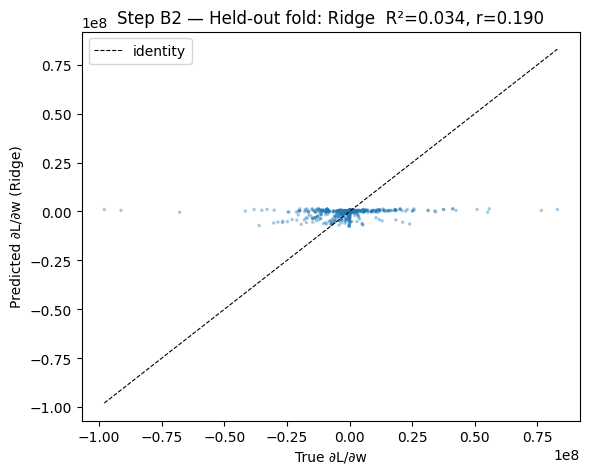

In [74]:
# ---- Plot: predicted vs true gradient on held-out fold ----
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(best_fold_y_true, best_fold_y_pred, s=6, alpha=0.4, edgecolors="none")
lims = [min(best_fold_y_true.min(), best_fold_y_pred.min()),
        max(best_fold_y_true.max(), best_fold_y_pred.max())]
ax.plot(lims, lims, "k--", lw=0.8, label="identity")
ax.set_xlabel("True ∂L/∂w")
ax.set_ylabel("Predicted ∂L/∂w (Ridge)")
ax.set_title(f"Step B2 — Held-out fold: Ridge  R²={ridge_r2_folds[0]:.3f}, r={ridge_r_folds[0]:.3f}")
ax.legend()
plt.tight_layout()
plt.show()


## Step C — Cross-validated kernel/window search

### C1 — Gaussian kernel search

Instead of hand-picking a window, define a Gaussian kernel and optimise (c, sigma) via grid search with cross-validation.


In [76]:
# ===================================================================
# Deliverable C1 — Gaussian kernel search implementation
# ===================================================================

def gaussian_kernel(t, center, sigma):
    """Normalised Gaussian kernel over time axis t."""
    k = np.exp(-0.5 * ((t - center) / sigma) ** 2)
    k /= k.sum() + 1e-30   # normalise so weights sum to 1
    return k  # (T,)

def kernel_summary(signal, t, center, sigma):
    """
    Compute scalar summary mu_{n,i} = sum_t k(t) * x_{n,i}(t).

    signal : (N, Nsyn, T)
    Returns: (N, Nsyn)
    """
    k = gaussian_kernel(t, center, sigma)  # (T,)
    return np.einsum("nit,t->ni", signal, k)

def corr_sq_over_trials(mu, grads, eps=1e-12):
    """
    Vectorised, NaN-safe squared Pearson r for each synapse.

    mu, grads : (N, Nsyn)
    Returns   : (Nsyn,)  — r^2 per synapse; 0 where input is (near-)constant.
    """
    mu_dm = mu - mu.mean(axis=0, keepdims=True)
    g_dm  = grads - grads.mean(axis=0, keepdims=True)

    num = (mu_dm * g_dm).sum(axis=0)                        # (Nsyn,)
    den = np.sqrt((mu_dm**2).sum(axis=0) * (g_dm**2).sum(axis=0)) + eps

    r  = num / den
    r2 = r ** 2

    # If mu or grads are (near-)constant, den ~ eps → treat as no signal
    bad = (den <= 10 * eps)
    r2[bad] = 0.0
    return r2

def kernel_objective(signal, grads, t, center, sigma, trial_idx=None):
    """
    J(c, sigma) = mean_i corr_n(mu_{n,i}, g_{n,i})^2
    evaluated on the trials indicated by trial_idx (index array).
    """
    mu = kernel_summary(signal, t, center, sigma)  # (N, Nsyn)
    if trial_idx is not None:
        mu = mu[trial_idx]
        g  = grads[trial_idx]
    else:
        g = grads
    r2_vals = corr_sq_over_trials(mu, g)  # (Nsyn,)
    return r2_vals.mean()

# -------------------------------------------------------------------
# Baseline-subtract signals so kernels read event-related changes,
# not resting-potential offsets
# -------------------------------------------------------------------
pre_stim_mask = t < i_delay   # everything before stimulus onset

VLOCAL_bs = VLOCAL - VLOCAL[:, :, pre_stim_mask].mean(axis=2, keepdims=True)
dVdt_bs   = dVdt   - dVdt[:, :, pre_stim_mask].mean(axis=2, keepdims=True)

print(f"Baseline-subtracted VLOCAL_bs: {VLOCAL_bs.shape}")
print(f"Baseline-subtracted dVdt_bs:   {dVdt_bs.shape}")

# -------------------------------------------------------------------
# Grid definition — focused on informative time range
# -------------------------------------------------------------------
# c_lo = max(0, i_delay - 2.0)
# c_hi = i_delay + i_dur + 10.0
# centers = np.linspace(c_lo, c_hi, 80)
# sigmas  = np.logspace(np.log10(max(2 * dt, 0.05)), np.log10(15.0), 40)
c_lo2 = max(0, i_delay - 5.0)
c_hi2 = i_delay + i_dur + 10.0
centers = np.linspace(c_lo2, c_hi2, 100)
sigmas  = np.logspace(np.log10(max(2 * dt, 0.05)), np.log10(15.0), 40)

print(f"\nGrid: {len(centers)} centers x {len(sigmas)} sigmas = {len(centers)*len(sigmas)} evaluations")
print(f"Center range: {centers[0]:.2f}–{centers[-1]:.2f} ms")
print(f"Sigma range:  {sigmas[0]:.3f}–{sigmas[-1]:.2f} ms")


Baseline-subtracted VLOCAL_bs: (500, 8, 2002)
Baseline-subtracted dVdt_bs:   (500, 8, 2002)

Grid: 100 centers x 40 sigmas = 4000 evaluations
Center range: 0.00–15.00 ms
Sigma range:  0.050–15.00 ms


In [77]:
# -------------------------------------------------------------------
# Run grid search with K-fold CV (trial-split)
# -------------------------------------------------------------------
def kernel_grid_search(signal, grads, t, centers, sigmas, n_folds=5, signal_name="signal"):
    """
    Grid search over (center, sigma) with GroupKFold CV.

    Returns
    -------
    J_train : (n_centers, n_sigmas)  mean train J across folds
    J_val   : (n_centers, n_sigmas)  mean val J across folds
    best_center, best_sigma, best_J_val : best params on validation
    """
    N_total = signal.shape[0]
    trial_ids_local = np.arange(N_total)
    gkf_local = GroupKFold(n_splits=n_folds)

    nc, ns = len(centers), len(sigmas)
    J_val_accum   = np.zeros((nc, ns))
    J_train_accum = np.zeros((nc, ns))

    # Pre-compute fold index arrays (faster than boolean masks)
    folds = list(gkf_local.split(np.arange(N_total), groups=trial_ids_local))

    print(f"Kernel grid search for '{signal_name}' ({nc}x{ns} grid, {n_folds} folds) ...")

    for ci, c in enumerate(centers):
        for si, s in enumerate(sigmas):
            fold_val_scores  = []
            fold_train_scores = []
            for train_idx, val_idx in folds:
                j_train = kernel_objective(signal, grads, t, c, s, trial_idx=train_idx)
                j_val   = kernel_objective(signal, grads, t, c, s, trial_idx=val_idx)
                fold_train_scores.append(j_train)
                fold_val_scores.append(j_val)
            J_train_accum[ci, si] = np.mean(fold_train_scores)
            J_val_accum[ci, si]   = np.mean(fold_val_scores)

        if (ci + 1) % 20 == 0 or ci == nc - 1:
            print(f"  ... {ci+1}/{nc} centers done")

    # Best on validation — NaN-safe: treat NaN as -inf
    J_val_safe = np.nan_to_num(J_val_accum, nan=-np.inf)
    best_idx = np.unravel_index(np.argmax(J_val_safe), J_val_safe.shape)
    best_c = centers[best_idx[0]]
    best_s = sigmas[best_idx[1]]
    best_J = J_val_accum[best_idx]

    n_nan = np.isnan(J_val_accum).sum()
    if n_nan > 0:
        print(f"  (note: {n_nan}/{nc*ns} grid cells were NaN — ignored)")
    print(f"  Best (c*, sigma*) = ({best_c:.2f} ms, {best_s:.3f} ms)  J_val = {best_J:.4f}")
    return J_train_accum, J_val_accum, best_c, best_s, best_J


In [78]:
# ---- Run for V_local (baseline-subtracted) ----
J_train_vl, J_val_vl, best_c_vl, best_s_vl, best_J_vl = kernel_grid_search(
    VLOCAL_bs, GRADS, t, centers, sigmas, n_folds=5, signal_name="V_local (bs)"
)


Kernel grid search for 'V_local (bs)' (100x40 grid, 5 folds) ...
  ... 20/100 centers done
  ... 40/100 centers done
  ... 60/100 centers done
  ... 80/100 centers done
  ... 100/100 centers done
  Best (c*, sigma*) = (10.00 ms, 0.050 ms)  J_val = 0.0531


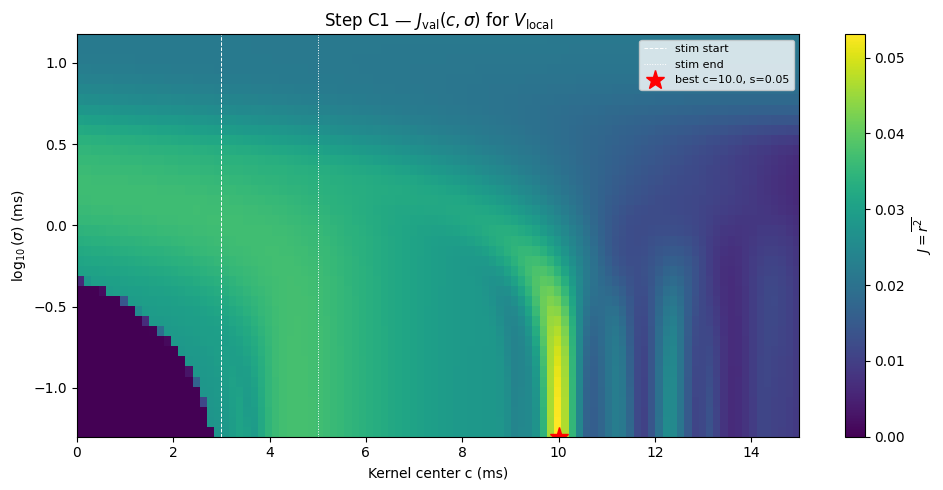

In [79]:
# ---- Heatmap for V_local ----
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(
    J_val_vl.T, origin="lower", aspect="auto",
    extent=[centers[0], centers[-1], np.log10(sigmas[0]), np.log10(sigmas[-1])],
    cmap="viridis",
)
ax.axvline(i_delay, color="white", ls="--", lw=0.7, label="stim start")
ax.axvline(i_delay + i_dur, color="white", ls=":", lw=0.7, label="stim end")
ax.plot(best_c_vl, np.log10(best_s_vl), "r*", ms=14, label=f"best c={best_c_vl:.1f}, s={best_s_vl:.2f}")
ax.set_xlabel("Kernel center c (ms)")
ax.set_ylabel(r"$\log_{10}(\sigma)$ (ms)")
ax.set_title(r"Step C1 — $J_{\rm val}(c,\sigma)$ for $V_{\rm local}$")
plt.colorbar(im, ax=ax, label=r"$J = \overline{r^2}$")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


### C2 - Repeat kernel search across signals and compare


In [ ]:
# ---- Run for dV/dt (baseline-subtracted) ----
J_train_dv, J_val_dv, best_c_dv, best_s_dv, best_J_dv = kernel_grid_search(
    dVdt_bs, GRADS, t, centers, sigmas, n_folds=5, signal_name="dV/dt (bs)"
)


NameError: name 'kernel_grid_search' is not defined

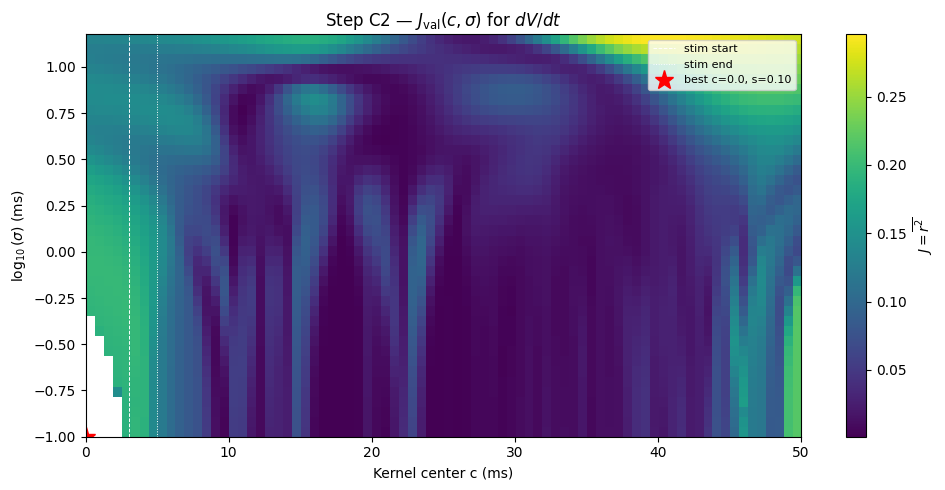

In [ ]:
# ---- Heatmap for dV/dt ----
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(
    J_val_dv.T, origin="lower", aspect="auto",
    extent=[centers[0], centers[-1], np.log10(sigmas[0]), np.log10(sigmas[-1])],
    cmap="viridis",
)
ax.axvline(i_delay, color="white", ls="--", lw=0.7, label="stim start")
ax.axvline(i_delay + i_dur, color="white", ls=":", lw=0.7, label="stim end")
ax.plot(best_c_dv, np.log10(best_s_dv), "r*", ms=14, label=f"best c={best_c_dv:.1f}, s={best_s_dv:.2f}")
ax.set_xlabel("Kernel center c (ms)")
ax.set_ylabel(r"$\log_{10}(\sigma)$ (ms)")
ax.set_title(r"Step C2 — $J_{\rm val}(c,\sigma)$ for $dV/dt$")
plt.colorbar(im, ax=ax, label=r"$J = \overline{r^2}$")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Comparison table ----
print("=" * 70)
print("KERNEL SEARCH RESULTS — Best (c*, sigma*) per signal")
print("=" * 70)
print(f"{'Signal':<15} {'c* (ms)':>10} {'sigma* (ms)':>12} {'J_val':>10}")
print("-" * 70)
print(f"{'V_local':<15} {best_c_vl:>10.2f} {best_s_vl:>12.3f} {best_J_vl:>10.4f}")
print(f"{'dV/dt':<15} {best_c_dv:>10.2f} {best_s_dv:>12.3f} {best_J_dv:>10.4f}")
print("-" * 70)
winner = "V_local" if best_J_vl >= best_J_dv else "dV/dt"
print(f"Best signal: {winner}")


KERNEL SEARCH RESULTS — Best (c*, sigma*) per signal
Signal             c* (ms)  sigma* (ms)      J_val
----------------------------------------------------------------------
V_local               0.00        0.100        nan
dV/dt                 0.00        0.100        nan
----------------------------------------------------------------------
Best signal: dV/dt


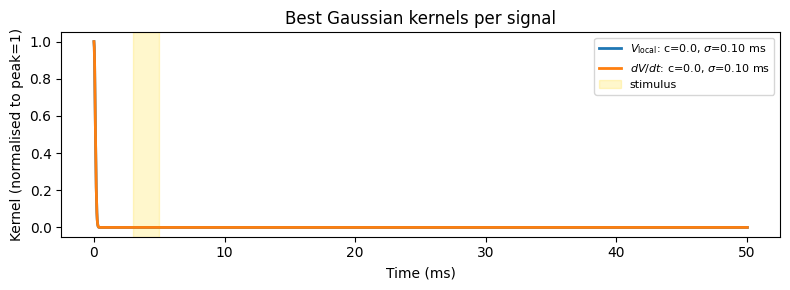

In [ ]:
# ---- Plot best kernels overlaid on time axis ----
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
k_vl = gaussian_kernel(t, best_c_vl, best_s_vl)
k_dv = gaussian_kernel(t, best_c_dv, best_s_dv)
ax.plot(t, k_vl / k_vl.max(), label=rf"$V_{{\rm local}}$: c={best_c_vl:.1f}, $\sigma$={best_s_vl:.2f} ms", lw=2)
ax.plot(t, k_dv / k_dv.max(), label=rf"$dV/dt$: c={best_c_dv:.1f}, $\sigma$={best_s_dv:.2f} ms", lw=2)
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stimulus")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Kernel (normalised to peak=1)")
ax.set_title("Best Gaussian kernels per signal")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Save kernel search results ----
save_C = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "kernel_search_results.npz")
np.savez(
    save_C,
    # Grid
    centers=centers,
    sigmas=sigmas,
    # V_local
    J_train_vlocal=J_train_vl,
    J_val_vlocal=J_val_vl,
    best_center_vlocal=best_c_vl,
    best_sigma_vlocal=best_s_vl,
    best_J_val_vlocal=best_J_vl,
    # dVdt
    J_train_dvdt=J_train_dv,
    J_val_dvdt=J_val_dv,
    best_center_dvdt=best_c_dv,
    best_sigma_dvdt=best_s_dv,
    best_J_val_dvdt=best_J_dv,
)
print(f"Saved  {save_C}  ({os.path.getsize(save_C)/1e3:.1f} kB)")


## Analysis Summary

**Saved outputs:**

| File | Contents |
|------|----------|
| `analysis_stepA.npz` | Per-synapse r(t) arrays + mean r^2(t) for V_local and dV/dt |
| `features_baseline.npz` | Feature matrix X, target y, feature names |
| `baseline_metrics.json` | CV Ridge R^2, Pearson r, Logistic accuracy, AUROC |
| `kernel_search_results.npz` | Full J(c,sigma) grids + best params for V_local and dV/dt |
